In [1]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random

from bbutils import BetaBernoulli

In [2]:
category2idx = dict()
idx2category = []
categories = []
observations = []

with open('data/cifar100/predictions.txt', 'r') as f:
    next(f)
    for line in f:
        _, correct, predicted, confidence = line.split()
        
        if predicted not in category2idx:
            category2idx[predicted] = len(category2idx)
            idx2category.append(predicted)
        idx = category2idx[predicted]
        
        categories.append(idx)
        observations.append(correct == predicted)
num_classes = 100

In [3]:
# Try to identify worst class

n = 501
k = num_classes
runs = 10000
# pseudo_count = 2
mode = 'min'

active_choices = np.zeros((runs, k, n))
active_thetas = np.zeros((runs, k, n))
random_thetas = np.zeros((runs, k, n))

for r in range(runs):

    # Queue choices for each category
    deques = [deque() for _ in range(k)]
    for category, observation in zip(categories, observations):
        deques[category].append(observation)
    ### THIS IS IMPORTANT ###
    for _deque in deques:
        random.shuffle(_deque)
   ####

    # Random model
    model = BetaBernoulli(k)

#     # Prior
#     # model._params = np.vstack((alpha, beta)).T

    n_success = 0
    total = 0
    for i in range(n):
        while True:
            category = random.randrange(k)
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        model.update(category, observation)
        random_thetas[r, :, i] = model._params[:,0] / (model._params[:,0] + model._params[:,1])
    
    # Queue choices for each category
    deques = [deque() for _ in range(k)]
    for category, observation in zip(categories, observations):
        deques[category].append(observation)
    ### THIS IS IMPORTANT ###
    for _deque in deques:
        random.shuffle(_deque)
   ####

    # Beta Bernoulli model
    model = BetaBernoulli(k)

    # Prior
    # model._params = np.vstack((alpha, beta)).T

    n_success = 0
    total = 0

    for i in range(n):
        theta_hat = model.sample()
        
        if mode == 'max':
            choices = np.argsort(theta_hat)[::-1]
        elif mode == 'min':
            choices = np.argsort(theta_hat)
            
        for j in range(k):
            category = choices[j]
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        model.update(category, observation)
        #beta_bernoulli_outcome[i] = n_success / (total + 1e-13)
        active_thetas[r, :, i] = model._params[:,0] / (model._params[:,0] + model._params[:,1])
        if i > 0:
            active_choices[r, :, i] = active_choices[r, :, i - 1]
        active_choices[r, category, i] += 1

In [4]:
correct = np.zeros(k)
total = np.zeros(k)

for category, observation in zip(categories, observations):
    if observation:
        correct[category] += 1
    total[category] += 1
    
empirical_acc = correct / total
ranked = np.argsort(empirical_acc)[::-1]

lizard
seal
otter
shrew
boy
woman
bear
couch
shark
baby


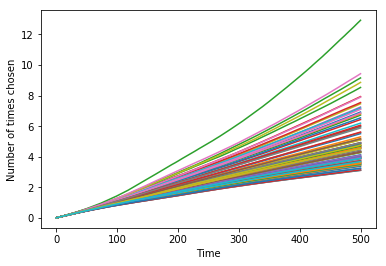

In [5]:
avg_active_choices = np.mean(active_choices, axis=0)

for i in range(k):
    plt.plot(avg_active_choices[i,:])
    plt.xlabel('Time')
    plt.ylabel('Number of times chosen')

top = np.argsort(avg_active_choices[:,-1])[::-1]

for i in top[:10]:
    print(idx2category[i])

In [6]:
most_chosen = np.argmax(active_choices[:, :, :], axis=1)

cutoff = 9

if mode == 'max':
    selection = ranked[:cutoff]
elif mode == 'min':
    selection = ranked[-cutoff:]
    selection = selection[::-1]
    
timestamps = [100, 200, 300, 400, 500]

table = np.zeros((cutoff+1, len(timestamps)))
    
for i, category in enumerate(selection):
    for j, timestamp in enumerate(timestamps):
        table[i,j] = np.mean(most_chosen[:,timestamp] == category)

table[cutoff,:] = 1 - np.sum(table, axis=0)

In [7]:
header = ' ' * 10 + ' '.join('%6i' % x for x in timestamps)
print(header)

for i, row in enumerate(table):
    if i < cutoff:
        category = idx2category[selection[i]]
    else:
        category = 'OTHER'
    category_string = '{:10s}'.format(category)
    num_string = ' '.join('{:.04f}'.format(x) for x in row.tolist())
    print(category_string + num_string)

             100    200    300    400    500
lizard    0.0462 0.1005 0.1394 0.1808 0.2235
seal      0.0280 0.0504 0.0630 0.0753 0.0799
otter     0.0619 0.0652 0.0715 0.0795 0.0865
shrew     0.0258 0.0456 0.0553 0.0594 0.0689
boy       0.0297 0.0498 0.0543 0.0581 0.0607
bear      0.0222 0.0339 0.0378 0.0404 0.0424
woman     0.0257 0.0383 0.0416 0.0450 0.0437
couch     0.0304 0.0407 0.0392 0.0371 0.0352
shark     0.0356 0.0361 0.0378 0.0354 0.0353
OTHER     0.6945 0.5395 0.4601 0.3890 0.3239


In [8]:
random_success = np.mean(np.argmin(random_thetas, axis=1) == selection[0], axis=0)
active_success = np.mean(np.argmin(active_thetas, axis=1) == selection[0], axis=0)

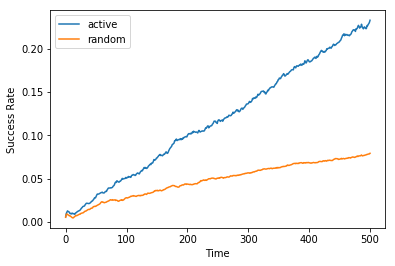

In [9]:
plt.plot(active_success, label='active')
plt.plot(random_success, label='random')
plt.xlabel('Time')
plt.ylabel('Success Rate')
plt.legend()